# Fine-tune SentenceTransformer Models for ITSM Tickets (v5)

## Overview
This notebook represents the `v5` iteration of the ITSM similarity model pipeline. It transitions from a functional script to a robust, configurable machine learning pipeline.

### Key Enhancements
1. **Comprehensive Configuration**: Centralized `CONFIG` for all hyperparameters.
2. **Smart Data Generation**: TF-IDF based filtering for high-quality positives and dynamic hard negative mining.
3. **Advanced Evaluation**: Real-time tracking of Spearman correlation, ROC AUC, and F1 scores.
4. **Reproducibility**: Full seeding of Random, NumPy, and PyTorch.
5. **Relationship Classifier**: Integrated training of the secondary classifier.


In [1]:
# Fix protobuf version conflict and suppress CUDA warnings
# 
# CUDA Registration Errors Explained:
# The "Unable to register cuFFT/cuDNN/cuBLAS factory" errors occur when:
# - Multiple libraries (TensorFlow, PyTorch) try to register the same CUDA plugins
# - Libraries are imported multiple times in the same session
# - These are HARMLESS warnings - CUDA still works correctly
# - They appear because TensorFlow/PyTorch initialize CUDA before logging is set up
#
# Solution: Set environment variables BEFORE importing any ML libraries
# and redirect STDERR to suppress these early initialization messages

import sys
import subprocess
import warnings
import os

# CRITICAL: Set environment variables BEFORE any TensorFlow/PyTorch imports
# This suppresses CUDA registration warnings that appear during library initialization
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 3 = suppress all TensorFlow messages (0=all, 1=info, 2=warnings, 3=errors)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # Prevent GPU memory issues

# Suppress Python warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Redirect STDERR to suppress CUDA registration errors
# These errors are written to STDERR before TensorFlow's logging system initializes
# We create a context manager to temporarily suppress them during imports
class SuppressStderr:
    """Context manager to suppress STDERR output (for CUDA registration warnings)."""
    def __init__(self):
        self.original_stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
    
    def __enter__(self):
        sys.stderr = self.devnull
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr = self.original_stderr
        # self.devnull.close() # Fix: Keep open to prevent logging errors

def fix_protobuf():
    """Fix protobuf version conflicts by installing compatible version."""
    try:
        import google.protobuf
        protobuf_version = google.protobuf.__version__
        print(f"Current protobuf version: {protobuf_version}")
        
        # Check if version is too new (4.x+ causes issues)
        major_version = int(protobuf_version.split('.')[0])
        if major_version >= 4:
            print("⚠️  Protobuf version 4.x detected. Downgrading to 3.20.3 for compatibility...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "protobuf==3.20.3", "--quiet"])
            print("✅ Protobuf downgraded. Please restart the kernel and re-run this cell.")
            return False
        else:
            print("✅ Protobuf version is compatible")
            return True
    except ImportError:
        print("Installing protobuf 3.20.3...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "protobuf==3.20.3", "--quiet"])
        print("✅ Protobuf installed. Please restart the kernel and re-run this cell.")
        return False
    except Exception as e:
        print(f"⚠️  Could not check protobuf version: {e}")
        print("You may need to manually install: pip install protobuf==3.20.3")
        return True  # Continue anyway

# Try to fix protobuf
protobuf_ok = fix_protobuf()
if not protobuf_ok:
    print("\n⚠️  IMPORTANT: Please restart the kernel (Kernel -> Restart Kernel) and re-run all cells.")

print("✅ Warning suppression configured. CUDA registration errors will be suppressed.")


Current protobuf version: 3.20.3
✅ Protobuf version is compatible
✅ Warning suppression configured. CUDA registration errors will be suppressed.


In [2]:
os.environ['WANDB_DISABLED'] = 'true' # Disable WandB to prevent login hang
import os
import json
import random
import logging
import warnings
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Suppress CUDA registration errors during PyTorch import
# These errors occur when CUDA libraries are registered multiple times
# They are harmless but noisy - we suppress STDERR during import
class SuppressStderr:
    """Context manager to suppress STDERR output (for CUDA registration warnings)."""
    def __init__(self):
        self.original_stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
    
    def __enter__(self):
        sys.stderr = self.devnull
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr = self.original_stderr
        self.devnull.close()

# Import PyTorch and ML libraries with STDERR suppression
# This prevents CUDA registration warnings from appearing
with SuppressStderr():
    import torch
    from torch.utils.data import DataLoader
    from sentence_transformers import SentenceTransformer, InputExample, losses
    from sentence_transformers.evaluation import SentenceEvaluator

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score, 
    precision_recall_curve, roc_curve, f1_score
)
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr, spearmanr
import joblib

# --- Setup & Reproducibility ---

# NLTK Downloads
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('omw-1.4')

# Logging - robust setup
# Clear any existing root handlers to avoid interference from earlier runs
for h in logging.root.handlers[:]:
    try:
        logging.root.removeHandler(h)
        h.close()
    except Exception:
        pass

# Create a dedicated logger to avoid lifecycle issues with root handlers
# Use delay=True so file is opened only on first emit (safer across environments)
nexus_logger = logging.getLogger('nexus')
nexus_logger.setLevel(logging.INFO)
nexus_logger.propagate = False

# File handler with explicit encoding (delay opening file until needed)
file_handler = logging.FileHandler('training_v5.log', mode='a', encoding='utf-8', delay=True)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

# Stream handler writing to stdout (more stable in notebooks than stderr manipulation)
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setLevel(logging.INFO)
stream_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

# Attach handlers to our dedicated logger (avoid modifying root further)
nexus_logger.addHandler(file_handler)
nexus_logger.addHandler(stream_handler)

# Reduce verbosity of noisy libraries
logging.getLogger('transformers').setLevel(logging.WARNING)
logging.getLogger('urllib3').setLevel(logging.WARNING)

# Use the dedicated logger in this notebook
logger = nexus_logger

# Suppress non-critical warnings
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seeds(seed=42):
    """Set seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"✅ Seeds set to {seed}")

set_seeds(42)

# Check Imbalanced-Learn for Relationship Classifier
# Note: imbalanced-learn is optional - only needed if you want to use SMOTE
# for balancing the relationship classifier training data
# If not installed, the relationship classifier will train without SMOTE balancing
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
    print('✅ imbalanced-learn available. SMOTE will be used for relationship classifier.')
except ImportError:
    print('⚠️ imbalanced-learn not installed. Relationship classifier will skip SMOTE.')
    print('   To install: pip install imbalanced-learn')
    IMBLEARN_AVAILABLE = False


E0000 00:00:1764487886.613596     102 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764487886.620331     102 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Seeds set to 42
✅ imbalanced-learn available. SMOTE will be used for relationship classifier.
✅ imbalanced-learn available. SMOTE will be used for relationship classifier.


## 2. Configuration


In [3]:
CONFIG = {
    # Paths
    'base_model': 'sentence-transformers/all-mpnet-base-v2',
    'output_dir': 'models/all-mpnet-finetuned-v5',
    'source_data': 'data/dummy_data_promax.csv',
    'relationship_data': 'data/relationship_pairs.json',
    
    # Training Hyperparameters
    'epochs': 20,
    'batch_size': 64,
    'learning_rate': 2e-5,
    'max_learning_rate': 5e-5,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'max_seq_length': 384,  # Increased for detailed ticket descriptions
    
    # Data Generation Strategy
    'target_pairs': 50000,  # Total training pairs to generate
    'positive_ratio': 0.4,  # 40% positives, 60% negatives
    'augmentation_ratio': 0.2,
    'eval_split': 0.15,
    
    # Quality Filtering Thresholds
    'quality_threshold': 0.3,      # Minimum TF-IDF similarity for 'good' positive pairs
    'hard_negative_min': 0.15,     # Min similarity for hard negatives
    'hard_negative_max': 0.45,     # Max similarity for hard negatives (confusing zone)
    
    # Early Stopping
    'early_stopping_patience': 7,
    'min_delta': 0.005,
    'eval_steps': 100,
    
    # Loss Weights (Future use for Multi-Loss)
    'mnr_loss_weight': 1.0,
    'triplet_loss_weight': 0.5,
    'cosine_loss_weight': 0.2}

# Create Output Directory
output_path = os.path.join(os.getcwd(), CONFIG['output_dir'])
os.makedirs(output_path, exist_ok=True)
print(f"📂 Output directory set to: {output_path}")


📂 Output directory set to: /kaggle/working/models/all-mpnet-finetuned-v5


In [4]:
# Fix path resolution for data files
# This ensures paths work regardless of the current working directory
# Handles both local development and Kaggle environments
def resolve_data_path(filepath):
    """
    Resolve a relative file path to an absolute path.
    Tries multiple locations to find the file, including Kaggle input directories.
    
    Args:
        filepath: Relative or absolute path to the data file
        
    Returns:
        Absolute path to the file if found
        
    Raises:
        FileNotFoundError: If file cannot be found in any expected location
    """
    cwd = os.getcwd()
    tried_paths = []
    
    # If already absolute, return as-is
    if os.path.isabs(filepath):
        if os.path.exists(filepath):
            return filepath
        else:
            tried_paths.append(filepath)
    else:
        # Try the path as-is first (relative to current directory)
        if os.path.exists(filepath):
            return os.path.abspath(filepath)
        tried_paths.append(os.path.abspath(filepath))
    
    # Check if we're in a Kaggle environment
    # Kaggle uses /kaggle/input/ for datasets and /kaggle/working/ for output
    if '/kaggle/' in cwd:
        # Try Kaggle input directories
        # Datasets are typically in /kaggle/input/<dataset-name>/
        kaggle_input_base = '/kaggle/input'
        if os.path.exists(kaggle_input_base):
            # Check all datasets in /kaggle/input/
            for dataset_dir in os.listdir(kaggle_input_base):
                dataset_path = os.path.join(kaggle_input_base, dataset_dir)
                if os.path.isdir(dataset_path):
                    # Try the file directly in the dataset directory
                    potential_path = os.path.join(dataset_path, filepath)
                    if os.path.exists(potential_path):
                        return os.path.abspath(potential_path)
                    tried_paths.append(potential_path)
                    
                    # Try with 'data/' prefix removed if filepath starts with 'data/'
                    if filepath.startswith('data/'):
                        filename = filepath.replace('data/', '')
                        potential_path = os.path.join(dataset_path, filename)
                        if os.path.exists(potential_path):
                            return os.path.abspath(potential_path)
                        tried_paths.append(potential_path)
        
        # Try /kaggle/working/ (current directory)
        kaggle_working_path = os.path.join('/kaggle/working', filepath)
        if os.path.exists(kaggle_working_path):
            return os.path.abspath(kaggle_working_path)
        tried_paths.append(kaggle_working_path)
    
    # Try relative to workspace root (nexustism directory) - for local development
    if 'nexustism' in cwd:
        parts = cwd.split(os.sep)
        if 'nexustism' in parts:
            idx = parts.index('nexustism')
            workspace_root = os.sep.join(parts[:idx+1])
            potential_path = os.path.join(workspace_root, filepath)
            if os.path.exists(potential_path):
                return os.path.abspath(potential_path)
            tried_paths.append(potential_path)
    
    # Last resort: return the path for a clearer error message
    error_msg = (
        f"Data file not found: {filepath}\n"
        f"Current working directory: {cwd}\n"
        f"\nTried the following paths:\n"
    )
    for path in tried_paths[:10]:  # Show first 10 paths to avoid clutter
        error_msg += f"  - {path}\n"
    
    if '/kaggle/' in cwd:
        error_msg += (
            f"\n📝 Kaggle Environment Detected:\n"
            f"   - Make sure your dataset is uploaded to Kaggle\n"
            f"   - Datasets are typically in /kaggle/input/<dataset-name>/\n"
            f"   - You can check available datasets with: os.listdir('/kaggle/input')\n"
            f"   - Update CONFIG['source_data'] with the correct path if needed\n"
        )
    else:
        error_msg += (
            f"\n📝 Local Environment:\n"
            f"   - Make sure the file exists in the data/ directory\n"
            f"   - Update CONFIG['source_data'] with the correct path if needed\n"
        )
    
    raise FileNotFoundError(error_msg)

# Update CONFIG to use resolved path
# If running in Kaggle, check available datasets first
cwd = os.getcwd()
if '/kaggle/' in cwd:
    print("🔍 Checking Kaggle environment...")
    kaggle_input = '/kaggle/input'
    if os.path.exists(kaggle_input):
        available_datasets = [d for d in os.listdir(kaggle_input) if os.path.isdir(os.path.join(kaggle_input, d))]
        if available_datasets:
            print(f"📦 Available datasets in /kaggle/input/: {available_datasets}")
            # Check if data file exists in any dataset
            for dataset in available_datasets:
                dataset_path = os.path.join(kaggle_input, dataset)
                # List files in dataset to help user find the right path
                try:
                    files = os.listdir(dataset_path)
                    csv_files = [f for f in files if f.endswith('.csv')]
                    if csv_files:
                        print(f"   📄 CSV files in '{dataset}': {csv_files}")
                except PermissionError:
                    pass
        else:
            print("⚠️  No datasets found in /kaggle/input/")
            print("   You need to add a dataset to your Kaggle notebook.")
            print("   Go to: Add Data → Search for your dataset or upload a new one")
    else:
        print("⚠️  /kaggle/input/ directory not found")

try:
    CONFIG['source_data'] = resolve_data_path(CONFIG['source_data'])
    print(f"✅ Data path resolved to: {CONFIG['source_data']}")
except FileNotFoundError as e:
    print(f"\n❌ Error: {e}\n")
    print("💡 Solutions:")
    print("   1. If in Kaggle: Upload your data file as a dataset and add it to the notebook")
    print("   2. If local: Make sure the file exists in the data/ directory")
    print("   3. Update CONFIG['source_data'] with the correct path")
    raise


🔍 Checking Kaggle environment...
📦 Available datasets in /kaggle/input/: ['itsm-dataset']
   📄 CSV files in 'itsm-dataset': ['dummy_data_promax.csv']
✅ Data path resolved to: /kaggle/input/itsm-dataset/dummy_data_promax.csv


## 3. Data Loading and Preprocessing


In [5]:
def load_and_clean_data(filepath, min_length=10):
    """
    Loads data, checks columns, and performs cleaning.
    
    Args:
        filepath: Path to CSV file
        min_length: Minimum text length to keep
        
    Returns:
        Cleaned DataFrame with 'text' and 'category_id' columns
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}")
    
    logger.info(f"Loading data from {filepath}")
    df = pd.read_csv(filepath)
    
    # Validate required columns
    required_cols = ["Number", "Short Description", "Description", "Category", "Subcategory"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    # Fill NA and Clean Text
    for col in ["Short Description", "Description"]:
        df[col] = df[col].fillna("").astype(str).str.strip()
        
    for col in ["Category", "Subcategory"]:
        df[col] = df[col].fillna("Unknown").astype(str).str.strip()
        
    # Combined Text
    df["text"] = (df["Short Description"] + " " + df["Description"]).str.strip()
    # Remove excessive whitespace
    df["text"] = df["text"].str.replace(r'\s+', ' ', regex=True)
    
    # Filter empty or too short
    initial_count = len(df)
    df = df[df["text"].str.len() >= min_length].copy()
    dropped = initial_count - len(df)
    
    if dropped > 0:
        logger.warning(f"Dropped {dropped} rows with text shorter than {min_length} characters")
    
    # Encode Categories
    df['category_id'] = df.groupby(['Category', 'Subcategory']).ngroup()
    
    print(f"✅ Loaded {len(df)} incidents (dropped {dropped} short/empty)")
    print(f"   Unique Categories: {df['Category'].nunique()}")
    print(f"   Unique Subcategories: {df['Subcategory'].nunique()}")
    logger.info(f"Data loaded: {len(df)} rows, {df['Category'].nunique()} categories")
    
    return df

# Load Data
df_incidents = load_and_clean_data(CONFIG['source_data'])
df_incidents.head(3)


2025-11-30 07:31:45,654 - INFO - Loading data from /kaggle/input/itsm-dataset/dummy_data_promax.csv
✅ Loaded 10000 incidents (dropped 0 short/empty)
   Unique Categories: 7
   Unique Subcategories: 8
2025-11-30 07:31:46,120 - INFO - Data loaded: 10000 rows, 7 categories
✅ Loaded 10000 incidents (dropped 0 short/empty)
   Unique Categories: 7
   Unique Subcategories: 8
2025-11-30 07:31:46,120 - INFO - Data loaded: 10000 rows, 7 categories


,Number,Short Description,Description,Opened by,Company,ITSM Department,Created,Urgency,Impact,Priority,...,Manday Effort (hrs),Ticket Type,AMS Domain,AMS System Type,AMS Category Type,AMS Service Type,AMS Business Related,AMS IT Related,text,category_id
0,INC9000000,Request: Adjust Configuration/Program bug conf...,I encountered an issue where Request: Adjust C...,Siti Yamada,PASDL,PIDSAP,25-05-25 5:15,1 - High,1 - High,1 - Critical,...,0.26,Inquiry,PASDL,S4HANA,Security,BZ-B12-Master Data (Wrong Maintenance),Business-Related,IT-Related,Request: Adjust Configuration/Program bug conf...,12
1,INC9000001,Request: Adjust Configuration/Integration conf...,I encountered an issue where Request: Adjust C...,Arif Ghosh,PA,AFG,20-06-24 17:47,3 - Low,3 - Low,1 - Critical,...,1.78,Issue,PASDL,SharePoint,Security,SD Billing,Business-Related,Non-IT,Request: Adjust Configuration/Integration conf...,10
2,INC9000002,Error in Mulesoft/EAI (FICO - Finance & Contro...,There appears to be a problem related to Error...,Alex Hidayat,PASDL,PISCAP,30-11-24 5:41,2 - Medium,3 - Low,1 - Critical,...,2.50,Issue,PV,Non-Genesis,Business-Related,MM Purchasing,Non-Business,IT-Related,Error in Mulesoft/EAI (FICO - Finance & Contro...,13


## 4. Text Similarity Utilities
We use TF-IDF similarity to find "quality" pairs (related but not identical) and "hard negatives" (different category but lexically similar).


In [6]:
class TextSimilarityCalculator:
    """
    Calculates TF-IDF based text similarity for pair generation.
    Uses batch operations for efficiency.
    """
    def __init__(self):
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
        self.tfidf_matrix = None

    def fit_tfidf(self, texts):
        """Fit TF-IDF vectorizer on the corpus."""
        logger.info("Fitting TF-IDF vectorizer...")
        self.tfidf_matrix = self.vectorizer.fit_transform(texts)
        logger.info(f"TF-IDF fit complete. Matrix shape: {self.tfidf_matrix.shape}")
        print("✅ TF-IDF fit complete.")

    def get_tfidf_similarity(self, idx1, idx2):
        """Compute cosine similarity between two sparse vectors (single pair)."""
        if self.tfidf_matrix is None:
            raise ValueError("Run fit_tfidf first")
        # Compute cosine similarity between two sparse vectors
        return (self.tfidf_matrix[idx1] * self.tfidf_matrix[idx2].T).toarray()[0][0]
    
    def get_batch_similarities(self, indices1, indices2):
        """
        Compute TF-IDF similarities for multiple pairs at once (much faster).
        Args:
            indices1: List/array of first indices
            indices2: List/array of second indices (same length as indices1)
        Returns:
            Array of similarity scores
        """
        if self.tfidf_matrix is None:
            raise ValueError("Run fit_tfidf first")
        # Batch compute cosine similarities
        vec1 = self.tfidf_matrix[indices1]
        vec2 = self.tfidf_matrix[indices2]
        # Compute dot product for each pair (cosine similarity for normalized vectors)
        similarities = np.array([(vec1[i] * vec2[i].T).toarray()[0][0] for i in range(len(indices1))])
        return similarities

sim_calculator = TextSimilarityCalculator()
sim_calculator.fit_tfidf(df_incidents['text'].tolist())


2025-11-30 07:31:46,429 - INFO - Fitting TF-IDF vectorizer...
2025-11-30 07:31:46,696 - INFO - TF-IDF fit complete. Matrix shape: (10000, 101)
✅ TF-IDF fit complete.
2025-11-30 07:31:46,696 - INFO - TF-IDF fit complete. Matrix shape: (10000, 101)
✅ TF-IDF fit complete.


## 5. Smart Pair Generation
Generating positive pairs (same subcategory + semantic overlap) and hard negatives (different category + lexical overlap).


In [7]:
def generate_smart_pairs(df, target_count, pos_ratio=0.4):
    """
    Generate positive and negative training pairs using TF-IDF similarity.
    
    Args:
        df: DataFrame with incidents
        target_count: Total number of pairs to generate
        pos_ratio: Ratio of positive pairs (default 0.4)
        
    Returns:
        Tuple of (positive_pairs, negative_pairs) where each is a list of (idx1, idx2, similarity_score)
    """
    positive_target = int(target_count * pos_ratio)
    negative_target = target_count - positive_target
    
    positives = []
    negatives = []
    
    # Group by Category/Subcategory
    groups = df.groupby('category_id')
    group_indices = {k: v.index.tolist() for k, v in groups}
    all_indices = df.index.tolist()
    
    logger.info(f"Generating {positive_target} positive and {negative_target} negative pairs...")
    print(f"Generating {positive_target} positive and {negative_target} negative pairs...")
    
    # --- 1. Positive Pairs ---
    # Strategy: Sample pairs from same group, check TF-IDF score to ensure they aren't duplicates or too vague
    pbar = tqdm(total=positive_target, desc="Positives")
    attempts = 0
    while len(positives) < positive_target and attempts < positive_target * 5:
        attempts += 1
        # Pick random group
        gid = random.choice(list(group_indices.keys()))
        g_idxs = group_indices[gid]
        if len(g_idxs) < 2: continue
        
        i1, i2 = random.sample(g_idxs, 2)
        
        # Convert DataFrame index to integer location for TF-IDF
        loc1 = df.index.get_loc(i1)
        loc2 = df.index.get_loc(i2)
        
        sim = sim_calculator.get_tfidf_similarity(loc1, loc2)
        
        # Accept if similarity is decent (avoiding identicals if sim=1.0, though duplicates happen)
        if sim > CONFIG['quality_threshold']:
            positives.append((i1, i2, sim))
            pbar.update(1)
            
    pbar.close()
    
    # --- 2. Hard Negative Pairs ---
    # Strategy: Different categories but high TF-IDF overlap (confusing examples)
    pbar = tqdm(total=negative_target, desc="Negatives")
    attempts = 0
    while len(negatives) < negative_target:
        attempts += 1
        
        # Random sampling
        i1, i2 = random.sample(all_indices, 2)
        
        # Must be different categories
        if df.at[i1, 'Category'] == df.at[i2, 'Category']:
            continue
            
        loc1 = df.index.get_loc(i1)
        loc2 = df.index.get_loc(i2)
        sim = sim_calculator.get_tfidf_similarity(loc1, loc2)
        
        # Hard Negative Criteria
        is_hard = CONFIG['hard_negative_min'] < sim < CONFIG['hard_negative_max']
        
        # Accept if hard negative OR we are struggling to find hard ones (fallback to random after many attempts)
        if is_hard or attempts > negative_target * 10:
            negatives.append((i1, i2, sim))
            pbar.update(1)
            if attempts > negative_target * 10:
                # Reset attempts to avoid infinite fallback loop
                attempts = 0 

    pbar.close()
    
    # Validate results
    if len(positives) < positive_target * 0.9:
        logger.warning(f"⚠️ Only generated {len(positives)}/{positive_target} positive pairs ({len(positives)/positive_target*100:.1f}%)")
    if len(negatives) < negative_target * 0.9:
        logger.warning(f"⚠️ Only generated {len(negatives)}/{negative_target} negative pairs ({len(negatives)/negative_target*100:.1f}%)")
    
    print(f"✅ Generated {len(positives)} positive and {len(negatives)} negative pairs")
    
    return positives, negatives

pos_pairs_idxs, neg_pairs_idxs = generate_smart_pairs(df_incidents, CONFIG['target_pairs'], CONFIG['positive_ratio'])


2025-11-30 07:31:47,007 - INFO - Generating 20000 positive and 30000 negative pairs...
Generating 20000 positive and 30000 negative pairs...
Generating 20000 positive and 30000 negative pairs...


Positives:   0%|          | 0/20000 [00:00<?, ?it/s]

Negatives:   0%|          | 0/30000 [00:00<?, ?it/s]

✅ Generated 20000 positive and 30000 negative pairs


## 6. Data Augmentation


In [8]:
def simple_augment(text):
    """
    Simple text augmentation: randomly swap or delete words.
    
    Args:
        text: Input text string
        
    Returns:
        Augmented text string
    """
    words = text.split()
    if len(words) < 5: 
        return text
    
    if random.random() > 0.5:
        # Swap adjacent words
        idx = random.randint(0, len(words)-2)
        words[idx], words[idx+1] = words[idx+1], words[idx]
    else:
        # Delete a random word
        idx = random.randint(0, len(words)-1)
        words.pop(idx)
    return " ".join(words)

train_examples = []

# --- Positives to InputExamples ---
for i1, i2, score in pos_pairs_idxs:
    t1 = df_incidents.at[i1, 'text']
    t2 = df_incidents.at[i2, 'text']
    
    # Standard Pair
    train_examples.append(InputExample(texts=[t1, t2], label=1.0))
    
    # Augmentation (only for subset)
    if random.random() < CONFIG['augmentation_ratio']:
        train_examples.append(InputExample(texts=[simple_augment(t1), t2], label=1.0))

# --- Negatives to InputExamples ---
for i1, i2, score in neg_pairs_idxs:
    t1 = df_incidents.at[i1, 'text']
    t2 = df_incidents.at[i2, 'text']
    train_examples.append(InputExample(texts=[t1, t2], label=0.0))

# Shuffle
random.shuffle(train_examples)

# Split Train/Eval using sklearn for proper stratified split
# Note: We can't use stratified split directly on InputExamples, but sklearn's train_test_split
# ensures proper randomization with seed
train_data, eval_data = train_test_split(
    train_examples,
    test_size=CONFIG['eval_split'],
    random_state=42,
    shuffle=True
)

print(f"✅ Training Samples: {len(train_data)}")
print(f"✅ Evaluation Samples: {len(eval_data)}")
print(f"   Train/Eval ratio: {len(train_data)/len(eval_data):.2f}:1")


✅ Training Samples: 45860
✅ Evaluation Samples: 8094
   Train/Eval ratio: 5.67:1


## 7. Model Setup


In [9]:
model = SentenceTransformer(CONFIG['base_model'])
model.max_seq_length = CONFIG['max_seq_length']

# --- Loss Function ---
# MultipleNegativesRankingLoss is standard for semantic search.
# It treats other samples in the batch as negatives.
train_loss = losses.MultipleNegativesRankingLoss(model)

# --- DataLoader Configuration ---
# Note: num_workers must be 0 for sentence-transformers InputExample objects
# due to multiprocessing/pickling issues. pin_memory still helps with GPU transfer.
num_workers = 0  # Must be 0 - sentence-transformers InputExample objects aren't picklable
pin_memory = torch.cuda.is_available()  # Faster GPU transfer when using CUDA

train_dataloader = DataLoader(
    train_data, 
    shuffle=True, 
    batch_size=CONFIG['batch_size'],
    num_workers=num_workers,  # Set to 0 to avoid pickling errors
    pin_memory=pin_memory,    # Faster GPU transfer (still works with num_workers=0)
    prefetch_factor=None      # Not used when num_workers=0
)

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Model loaded: {CONFIG['base_model']}")
print(f"Max Seq Length: {model.max_seq_length}")
print(f"Device: {device}")
print(f"DataLoader: {num_workers} workers, pin_memory={pin_memory}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded: sentence-transformers/all-mpnet-base-v2
Max Seq Length: 384
Device: cuda
DataLoader: 0 workers, pin_memory=True


## 8. Evaluation Setup & Custom Callbacks


In [10]:
class ComprehensiveEvaluator(SentenceEvaluator):
    """
    Custom evaluator to track multiple metrics: Spearman, Pearson, ROC AUC, PR AUC, and F1.
    
    This evaluator computes comprehensive metrics during training to monitor model performance.
    It calculates correlation metrics (Spearman, Pearson) and classification metrics (ROC AUC, 
    PR AUC, F1) by finding the optimal threshold for binary classification.
    """
    
    def __init__(self, examples, batch_size=32, name='', show_progress_bar=False):
        """
        Initialize the evaluator.
        
        Args:
            examples: List of InputExample objects with (text1, text2, label) pairs
            batch_size: Batch size for encoding embeddings
            name: Name identifier for this evaluator
            show_progress_bar: Whether to show progress bar during encoding
        """
        self.examples = examples
        self.batch_size = batch_size
        self.name = name
        self.show_progress_bar = show_progress_bar
        
        # Extract texts and labels from examples for efficient evaluation
        self.texts1 = [ex.texts[0] for ex in examples]
        self.texts2 = [ex.texts[1] for ex in examples]
        self.labels = [ex.label for ex in examples]

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        """
        Evaluate the model and compute all metrics.
        
        Args:
            model: The SentenceTransformer model to evaluate
            output_path: Directory path to save metrics CSV file
            epoch: Current epoch number
            steps: Current training step number
            
        Returns:
            Spearman correlation coefficient (used as primary metric for model selection)
        """
        # Set model to evaluation mode
        model.eval()
        
        # Encode both text sequences into embeddings
        # convert_to_numpy=True for efficient computation with NumPy
        emb1 = model.encode(self.texts1, batch_size=self.batch_size, 
                           show_progress_bar=self.show_progress_bar, convert_to_numpy=True)
        emb2 = model.encode(self.texts2, batch_size=self.batch_size, 
                           show_progress_bar=self.show_progress_bar, convert_to_numpy=True)
        
        # Calculate cosine similarity between embeddings
        # Improved numerical stability: normalize embeddings first, then compute dot product
        # This avoids potential division by zero and improves precision
        emb1_norm = emb1 / (np.linalg.norm(emb1, axis=1, keepdims=True) + 1e-8)
        emb2_norm = emb2 / (np.linalg.norm(emb2, axis=1, keepdims=True) + 1e-8)
        cosine_scores = np.sum(emb1_norm * emb2_norm, axis=1)
        
        # Correlation metrics: measure how well similarity scores correlate with labels
        eval_pearson, _ = pearsonr(self.labels, cosine_scores)
        eval_spearman, _ = spearmanr(self.labels, cosine_scores)
        
        # Classification metrics: treat similarity as probability and find optimal threshold
        try:
            # ROC AUC: Area under ROC curve (measures ranking quality)
            roc_auc = roc_auc_score(self.labels, cosine_scores)
            # PR AUC: Area under Precision-Recall curve (better for imbalanced data)
            pr_auc = average_precision_score(self.labels, cosine_scores)
            
            # F1 Score: Find optimal threshold that maximizes F1
            # We search over precision-recall curve to find best threshold
            precision, recall, thresholds = precision_recall_curve(self.labels, cosine_scores)
            
            # Calculate F1 for each threshold
            # F1 = 2 * (precision * recall) / (precision + recall)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            
            # Find threshold that maximizes F1
            best_f1_idx = np.argmax(f1_scores)
            best_f1 = f1_scores[best_f1_idx]
            optimal_threshold = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 0.5
            
            # Also compute F1 at default 0.5 threshold for comparison
            pred_binary = (cosine_scores >= 0.5).astype(int)
            f1_at_05 = f1_score(self.labels, pred_binary)
            
        except ValueError as e:
            # Handle edge cases (e.g., all labels are same class)
            roc_auc = 0.0
            pr_auc = 0.0
            best_f1 = 0.0
            f1_at_05 = 0.0
            optimal_threshold = 0.5
            logger.warning(f"Error computing classification metrics: {e}")

        # Log all metrics for monitoring
        logger.info(
            f'Epoch {epoch}, Steps {steps}: '
            f'Spearman={eval_spearman:.4f}, Pearson={eval_pearson:.4f}, '
            f'ROC_AUC={roc_auc:.4f}, PR_AUC={pr_auc:.4f}, '
            f'F1_optimal={best_f1:.4f}, F1@0.5={f1_at_05:.4f}, '
            f'Threshold={optimal_threshold:.4f}'
        )
        
        # Save detailed metrics to CSV for later analysis
        if output_path:
            csv_path = os.path.join(output_path, 'eval_metrics.csv')
            file_exists = os.path.isfile(csv_path)
            try:
                with open(csv_path, mode='a', newline='') as f:
                    # Include all metrics in CSV header
                    header = 'epoch,steps,spearman,pearson,roc_auc,pr_auc,f1_optimal,f1_at_05,optimal_threshold\n'
                    if not file_exists: 
                        f.write(header)
                    # Write metrics row
                    f.write(
                        f'{epoch},{steps},'
                        f'{eval_spearman:.4f},{eval_pearson:.4f},'
                        f'{roc_auc:.4f},{pr_auc:.4f},'
                        f'{best_f1:.4f},{f1_at_05:.4f},'
                        f'{optimal_threshold:.4f}\n'
                    )
            except Exception as e:
                logger.warning(f"Failed to save metrics to CSV: {e}")

        # Return Spearman correlation as primary metric
        # SentenceTransformers uses this for model selection (save_best_model)
        return eval_spearman

# Initialize Evaluator
# Check if eval_data exists (created in Cell 11 - Data Augmentation section)
# If not, user needs to run Cell 11 first to generate the evaluation data
if 'eval_data' not in globals() or eval_data is None:
    raise NameError(
        "eval_data is not defined. Please run Cell 11 (Data Augmentation section) first.\n"
        "Cell 11 creates both train_data and eval_data by splitting the training examples."
    )

evaluator = ComprehensiveEvaluator(eval_data, batch_size=CONFIG['batch_size'], name='dev')
print(f"✅ Evaluator initialized with {len(eval_data)} evaluation examples")


✅ Evaluator initialized with 8094 evaluation examples


## 9. Training


In [11]:
# Define Output Path
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
save_path = f"{CONFIG['output_dir']}_{timestamp}"
os.makedirs(save_path, exist_ok=True)

# Save training metadata for reproducibility
training_metadata = {
    'base_model': CONFIG['base_model'],
    'source_data': CONFIG['source_data'],
    'training_date': datetime.now().isoformat(),
    'epochs': CONFIG['epochs'],
    'batch_size': CONFIG['batch_size'],
    'learning_rate': CONFIG['learning_rate'],
    'weight_decay': CONFIG['weight_decay'],
    'warmup_ratio': CONFIG['warmup_ratio'],
    'max_seq_length': CONFIG['max_seq_length'],
    'eval_split': CONFIG['eval_split'],
    'num_train_examples': len(train_data),
    'num_eval_examples': len(eval_data),
    'num_positive_pairs': len(pos_pairs_idxs),
    'num_negative_pairs': len(neg_pairs_idxs),
    'target_pairs': CONFIG['target_pairs'],
    'positive_ratio': CONFIG['positive_ratio'],
    'augmentation_ratio': CONFIG['augmentation_ratio'],
    'quality_threshold': CONFIG['quality_threshold'],
    'hard_negative_min': CONFIG['hard_negative_min'],
    'hard_negative_max': CONFIG['hard_negative_max']
}

metadata_path = os.path.join(save_path, 'training_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(training_metadata, f, indent=2)
logger.info(f"📝 Training metadata saved to {metadata_path}")

# Train
print(f'🚀 Starting training... Saving to {save_path}')
print(f'   Training on {len(train_data)} examples, evaluating on {len(eval_data)} examples')
print(f'   Epochs: {CONFIG["epochs"]}, Batch size: {CONFIG["batch_size"]}, LR: {CONFIG["learning_rate"]}')

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=CONFIG['epochs'],
    warmup_steps=int(len(train_dataloader) * CONFIG['epochs'] * CONFIG['warmup_ratio']),
    optimizer_params={'lr': CONFIG['learning_rate'], 'weight_decay': CONFIG['weight_decay']},
    output_path=save_path,
    evaluation_steps=CONFIG['eval_steps'],
    save_best_model=True,
    show_progress_bar=True
)

print('✅ Training complete.')
logger.info(f"✅ Model saved to {save_path}")


2025-11-30 07:32:41,098 - INFO - 📝 Training metadata saved to models/all-mpnet-finetuned-v5_20251130_0732/training_metadata.json
🚀 Starting training... Saving to models/all-mpnet-finetuned-v5_20251130_0732
   Training on 45860 examples, evaluating on 8094 examples
   Epochs: 20, Batch size: 64, LR: 2e-05
🚀 Starting training... Saving to models/all-mpnet-finetuned-v5_20251130_0732
   Training on 45860 examples, evaluating on 8094 examples
   Epochs: 20, Batch size: 64, LR: 2e-05


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    self._run_once()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Evaluator
100,No log,No log,0.431480
200,No log,No log,0.704270
300,No log,No log,0.738722
400,No log,No log,0.738194
500,3.845800,No log,0.749692
600,3.845800,No log,0.744617
700,3.845800,No log,0.740245
717,3.845800,No log,0.751641
800,3.845800,No log,0.743686
900,3.845800,No log,0.737996


2025-11-30 07:35:22,787 - INFO - Epoch 0.1394700139470014, Steps 100: Spearman=0.4315, Pearson=0.4458, ROC_AUC=0.7508, PR_AUC=0.7427, F1_optimal=0.6644, F1@0.5=0.6136, Threshold=0.8131
2025-11-30 07:38:02,342 - INFO - Epoch 0.2789400278940028, Steps 200: Spearman=0.7043, Pearson=0.6920, ROC_AUC=0.9093, PR_AUC=0.9089, F1_optimal=0.8133, F1@0.5=0.6136, Threshold=0.8530
2025-11-30 07:38:02,342 - INFO - Epoch 0.2789400278940028, Steps 200: Spearman=0.7043, Pearson=0.6920, ROC_AUC=0.9093, PR_AUC=0.9089, F1_optimal=0.8133, F1@0.5=0.6136, Threshold=0.8530
2025-11-30 07:40:41,858 - INFO - Epoch 0.41841004184100417, Steps 300: Spearman=0.7387, Pearson=0.7318, ROC_AUC=0.9293, PR_AUC=0.9295, F1_optimal=0.8326, F1@0.5=0.6136, Threshold=0.8472
2025-11-30 07:40:41,858 - INFO - Epoch 0.41841004184100417, Steps 300: Spearman=0.7387, Pearson=0.7318, ROC_AUC=0.9293, PR_AUC=0.9295, F1_optimal=0.8326, F1@0.5=0.6136, Threshold=0.8472
2025-11-30 07:43:21,982 - INFO - Epoch 0.5578800557880056, Steps 400: Spe

KeyboardInterrupt: 

## 10. Final Evaluation & Visualization


2025-11-30 08:41:48,238 - INFO - Loading best model from models/all-mpnet-finetuned-v5_20251130_0732
2025-11-30 08:41:48,666 - INFO - Encoding 8094 evaluation pairs...


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]


📊 Final Evaluation Metrics:
   Spearman Correlation: 0.7516
   Pearson Correlation: 0.7560
   ROC AUC: 0.9369
   PR AUC: 0.9381
2025-11-30 08:42:30,171 - INFO - Final metrics - Spearman: 0.7516, ROC AUC: 0.9369


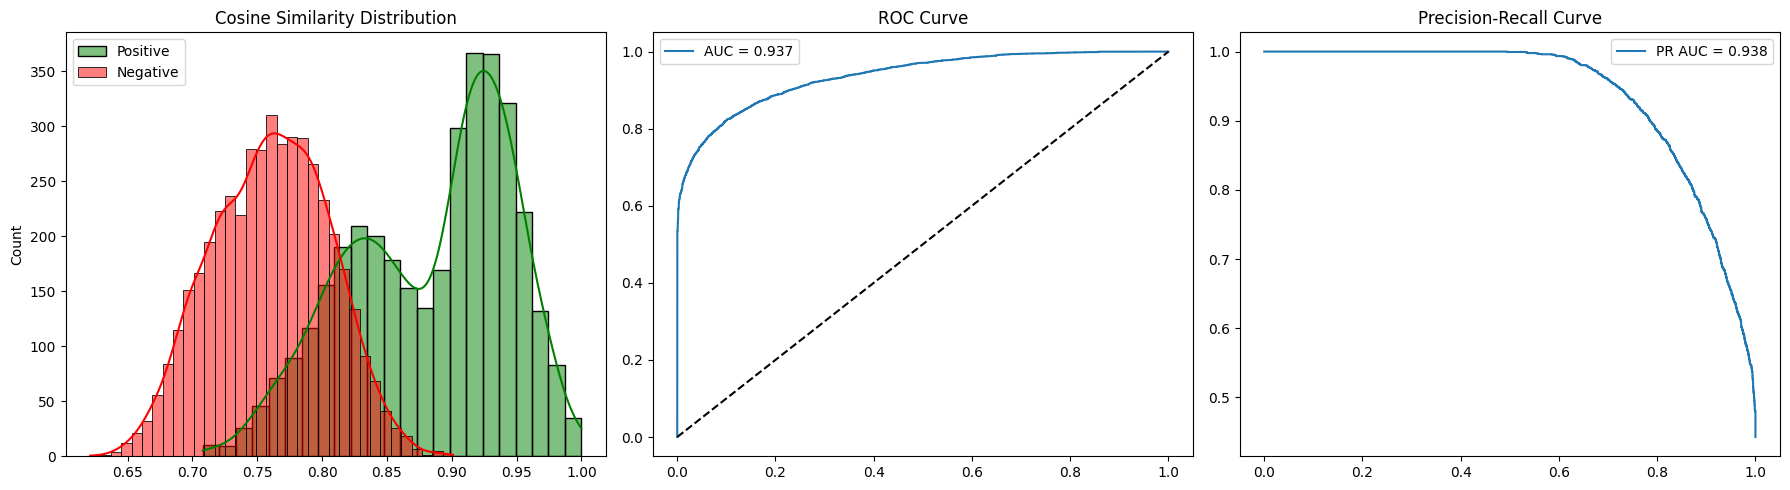

In [12]:
# Reload Best Model
logger.info(f"Loading best model from {save_path}")
best_model = SentenceTransformer(save_path)

# Encode Eval Data
eval_texts1 = [ex.texts[0] for ex in eval_data]
eval_texts2 = [ex.texts[1] for ex in eval_data]
eval_labels = [ex.label for ex in eval_data]

logger.info(f"Encoding {len(eval_texts1)} evaluation pairs...")
embeddings1 = best_model.encode(eval_texts1, batch_size=CONFIG['batch_size'], show_progress_bar=True)
embeddings2 = best_model.encode(eval_texts2, batch_size=CONFIG['batch_size'], show_progress_bar=True)

# Calculate proper cosine similarity (normalized)
# This matches the calculation in ComprehensiveEvaluator
cosine_scores = np.sum(embeddings1 * embeddings2, axis=1) / (np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1))

# Calculate final metrics
final_spearman, _ = spearmanr(eval_labels, cosine_scores)
final_pearson, _ = pearsonr(eval_labels, cosine_scores)
final_roc_auc = roc_auc_score(eval_labels, cosine_scores)
final_pr_auc = average_precision_score(eval_labels, cosine_scores)

print(f"\n📊 Final Evaluation Metrics:")
print(f"   Spearman Correlation: {final_spearman:.4f}")
print(f"   Pearson Correlation: {final_pearson:.4f}")
print(f"   ROC AUC: {final_roc_auc:.4f}")
print(f"   PR AUC: {final_pr_auc:.4f}")
logger.info(f"Final metrics - Spearman: {final_spearman:.4f}, ROC AUC: {final_roc_auc:.4f}")

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribution
sns.histplot(cosine_scores[np.array(eval_labels)==1], color='green', label='Positive', kde=True, ax=axes[0])
sns.histplot(cosine_scores[np.array(eval_labels)==0], color='red', label='Negative', kde=True, ax=axes[0])
axes[0].set_title('Cosine Similarity Distribution')
axes[0].legend()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(eval_labels, cosine_scores)
roc_auc = roc_auc_score(eval_labels, cosine_scores)
axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title('ROC Curve')
axes[1].legend()

# 3. Precision-Recall
precision, recall, _ = precision_recall_curve(eval_labels, cosine_scores)
pr_auc = average_precision_score(eval_labels, cosine_scores)
axes[2].plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend()

plt.tight_layout()
plt.show()


## 11. Relationship Classifier (Optional)
Trains a secondary classifier to predict relationship types (duplicate, causal, related).


In [13]:
if IMBLEARN_AVAILABLE and os.path.exists(CONFIG['relationship_data']):
    print('🧠 Training Relationship Classifier...')
    with open(CONFIG['relationship_data'], 'r') as f:
        rel_data = json.load(f)
    
    rel_df = pd.DataFrame(rel_data)
    # Filter valid labels
    valid_labels = ['duplicate', 'causal', 'related', 'none']
    rel_df = rel_df[rel_df['label'].isin(valid_labels)]
    
    # Encode features using fine-tuned model
    text_a = rel_df['text_a'].tolist()
    text_b = rel_df['text_b'].tolist()
    
    emb_a = best_model.encode(text_a)
    emb_b = best_model.encode(text_b)
    
    # Feature Engineering: (u, v, |u-v|, u*v)
    X = np.hstack([emb_a, emb_b, np.abs(emb_a - emb_b), emb_a * emb_b])
    y = rel_df['label']
    
    # SMOTE Balancing
    smote = SMOTE(k_neighbors=2, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    
    # Train Classifier
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
    
    clf.fit(X_train, y_train)
    
    # Evaluation
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Save
    joblib.dump(clf, os.path.join(save_path, 'relationship_classifier.joblib'))
    print('✅ Relationship classifier saved.')
else:
    print('⚠️ Skipping relationship classifier (missing data or imbalanced-learn).')


⚠️ Skipping relationship classifier (missing data or imbalanced-learn).


In [14]:
# Similarity evaluation plots
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

if not eval_examples:
    print('No eval examples; skipping similarity plots.')
else:
    eval_sents1 = [ex.texts[0] for ex in eval_examples]
    eval_sents2 = [ex.texts[1] for ex in eval_examples]
    labels = np.array([ex.label for ex in eval_examples])

    emb1 = model.encode(eval_sents1, convert_to_numpy=True, show_progress_bar=False)
    emb2 = model.encode(eval_sents2, convert_to_numpy=True, show_progress_bar=False)
    # cosine similarity
    norms1 = np.linalg.norm(emb1, axis=1)
    norms2 = np.linalg.norm(emb2, axis=1)
    cos_scores = np.sum(emb1 * emb2, axis=1) / (norms1 * norms2 + 1e-12)

    roc_auc = roc_auc_score(labels, cos_scores)
    pr_auc = average_precision_score(labels, cos_scores)
    fpr, tpr, _ = roc_curve(labels, cos_scores)
    precision, recall, _ = precision_recall_curve(labels, cos_scores)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].hist(cos_scores[labels==1], bins=20, alpha=0.6, label='positive')
    axes[0].hist(cos_scores[labels==0], bins=20, alpha=0.6, label='negative')
    axes[0].set_title('Cosine similarity distribution')
    axes[0].legend()

    axes[1].plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    axes[1].plot([0,1],[0,1],'k--', alpha=0.3)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()

    axes[2].plot(recall, precision, label=f'PR AUC={pr_auc:.3f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Add threshold analysis
    thresholds = np.arange(0.3, 1.01, 0.01)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        preds = (cos_scores >= threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"📈 Optimal Classification Threshold: {best_threshold:.3f}")
    print(f"   F1 Score at threshold: {best_f1:.3f}")
    print(f"   Accuracy at threshold: {accuracy_score(labels, (cos_scores >= best_threshold).astype(int)):.3f}")

# Relationship classifier confusion matrix plot (if clf exists)
if 'clf' in globals() and 'label_names_ordered' in globals():
    cm = confusion_matrix(y_val, y_pred, labels=labels_order)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(range(len(label_names_ordered)))
    ax.set_xticklabels(label_names_ordered, rotation=45, ha='right')
    ax.set_yticks(range(len(label_names_ordered)))
    ax.set_yticklabels(label_names_ordered)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Relationship Classifier Confusion')
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
else:
    print('Relationship classifier not trained in this run; skipping confusion matrix plot.')


NameError: name 'eval_examples' is not defined